### Evaluating Classification Models

**OBJECTIVES**
- Use the confusion matrix to evaluate classification models
- Use precision and recall to evaluate a classifier
- Explore lift and gain to evaluate classifiers
- Determine cost of predicting highest probability targets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.datasets import load_breast_cancer, load_digits, fetch_openml

### Problem

Below, a dataset with information on individuals and whether or not they have heart disease is loaded and displayed.  A `LogisticRegression` and `KNeighborsClassifier` are used to build predictive models on train/test splits.  Examine the  confusion matrices and explore the classifiers mistakes.  

- Which model do you prefer and why?
- Do you care about predicting each of these classes equally?
- Is there a ratio other than accuracy you think is more important based on the confusion matrix?  

In [2]:
heart = fetch_openml(data_id=43823).frame

In [3]:
heart.head()

,Age,Sex,Chest_pain_type,BP,Cholesterol,FBS_over_120,EKG_results,Max_HR,Exercise_angina,ST_depression,Slope_of_ST,Number_of_vessels_fluro,Thallium,Heart_Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


In [4]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest_pain_type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS_over_120             270 non-null    int64  
 6   EKG_results              270 non-null    int64  
 7   Max_HR                   270 non-null    int64  
 8   Exercise_angina          270 non-null    int64  
 9   ST_depression            270 non-null    float64
 10  Slope_of_ST              270 non-null    int64  
 11  Number_of_vessels_fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart_Disease            270 non-null    object 
dtypes: float64(1), int64(12), 

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score

In [6]:
X = heart.iloc[:, :-1]
y = heart['Heart_Disease']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 11)

In [9]:
#instantiate estimator with appropriate parameters
lgr = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=11)

In [10]:
#models require scaling data first
scaler = StandardScaler()

In [11]:
from sklearn.pipeline import Pipeline

In [12]:
#instantiate Pipeline's for each model
lgr_pipe = Pipeline([('scaler', scaler()), ('lgr', lgr)])
knn_pipe = Pipeline([('scaler', scaler()), ('knn', knn)])

In [13]:
#fit the models on the training data
lgr_pipe.fit(X_train, y_train)
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=11))])

In [16]:
#plot confusion matrices
from sklearn.metrics import ConfusionMatrixDisplay


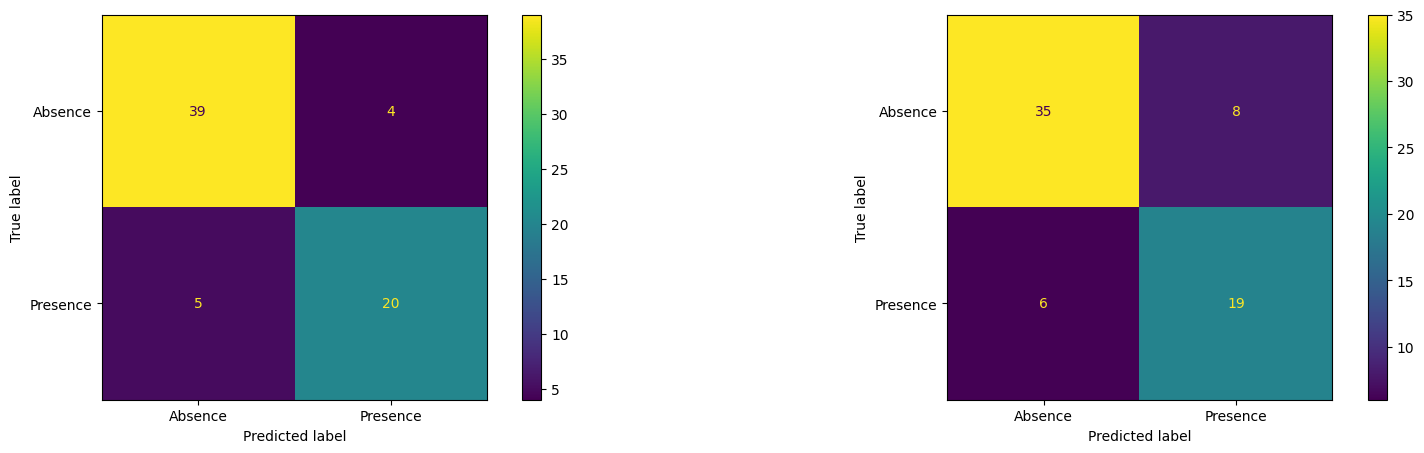

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))
ConfusionMatrixDisplay.from_estimator(lgr_pipe, X_test, y_test, ax = ax[0])
ConfusionMatrixDisplay.from_estimator(knn_pipe, X_test, y_test, ax = ax[1])

### Experimenting with `n_neighbors`

In the example above, we used a single value for `k` to predict heart disease.  As we discussed, different numbers of neighbors may be appropriate in different problems. To experiment with different numbers of neighbors we can use a `GridSearchCV` to search over different values of `k` and select the parameters that do the best at predicting on a test set.  Below, its use is demonstrated using a single estimator and a pipeline.

In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
knn = KNeighborsClassifier()
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [19]:
params_to_search = {'n_neighbors': [5, 9, 13, 17, 21, 29, 39]}

In [20]:
grid_search = GridSearchCV(estimator=knn, param_grid=params_to_search)

In [21]:
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 9, 13, 17, 21, 29, 39]})

In [22]:
grid_search.best_params_

{'n_neighbors': 21}

In [23]:
results = pd.DataFrame(grid_search.cv_results_)
results.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003309,0.001739,0.003583,0.000341,5,{'n_neighbors': 5},0.634146,0.634146,0.7,0.65,0.575,0.638659,0.039961,2


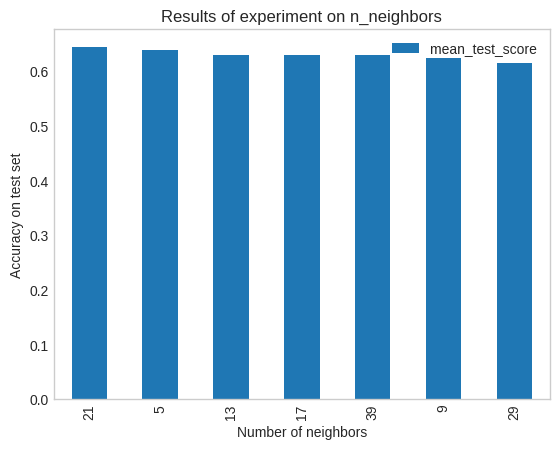

In [24]:
plt.style.use('seaborn-v0_8-whitegrid')
results.sort_values(by = 'mean_test_score', ascending = False).plot(kind = 'bar', x = 'param_n_neighbors', y = 'mean_test_score')
plt.grid()
plt.title('Results of experiment on n_neighbors')
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy on test set');

In [25]:
knn_pipe = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsClassifier())])
params = {'knn__n_neighbors': [5, 9, 13, 17, 21, 29, 39]}
grid_for_pipeline = GridSearchCV(knn_pipe, param_grid=params)

In [26]:
grid_for_pipeline.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [5, 9, 13, 17, 21, 29, 39]})

In [27]:
grid_for_pipeline.best_params_

{'knn__n_neighbors': 5}

**Expanding our metrics**

[<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/PrecisionrecallDogExample.svg/1024px-PrecisionrecallDogExample.svg.png" width=20% />]()

In [28]:
ex = np.array([[3, 7], [7, 5]])
ex

array([[3, 7],
       [7, 5]])

In [29]:
import seaborn as sns

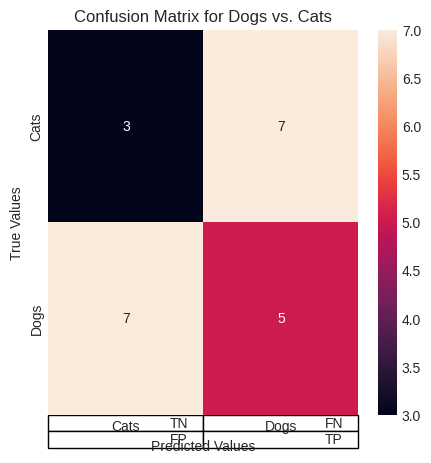

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sns.heatmap(ex, annot = True, ax = ax)
ax.set_yticks([0.5, 1.5], ['Cats', 'Dogs']);
ax.set_ylabel('True Values')
ax.set_xticks([0.5, 1.5], ['Cats', 'Dogs'])
ax.set_xlabel('Predicted Values')
ax.set_title('Confusion Matrix for Dogs vs. Cats');

ex2 = np.array([['TN', 'FN'], ['FP', 'TP']])
ax.table(ex2)

**Problem**

In our heart disease example, do you think you care more about predicting the presence of heart disease or the absence of it?  As such, which metric is more appropriate, precision or recall?  Look back at your confusion matrices and calculate the updated metric -- which estimator was better?

In [ ]:
#recall

 What is happening with the code below?

In [ ]:
y_train_num = np.where(y_train == 'Presence', 1, 0)
y_test_num = np.where(y_test == 'Presence', 1, 0)

In [ ]:
grid_to_select_best_recall = GridSearchCV(knn_pipe, param_grid=params, scoring = 'recall').fit(X_train, y_train_num)
print(f'Best recall: {grid_to_select_best_recall.score(X_test, y_test_num)}')

In [ ]:
grid_to_select_best_precision = GridSearchCV(knn_pipe, param_grid=params, scoring = 'precision').fit(X_train, y_train_num)
print(f'Best precision: {grid_to_select_best_precision.score(X_test, y_test_num)}')

### Problem

Below, a dataset around customer churn is loaded and displayed.  Classification models on the data are given and their confusion matrices.  

- Suppose you want to offer an incentive to customers you think are likely to churn, what is an appropriate evaluation metric? Why?


In [ ]:
churn = fetch_openml(data_id = 43390).frame

In [ ]:
churn.head()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
X = churn.iloc[:, :-1]
y = churn['Exited']
X.drop(['Surname', 'RowNumber', 'CustomerId'], axis = 1, inplace = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 11)

In [ ]:
encoder = make_column_transformer((OneHotEncoder(drop = 'first'), ['Geography', 'Gender']),
                                  remainder = StandardScaler())

In [ ]:
knn_pipe = Pipeline([('transform', encoder), ('model', KNeighborsClassifier())])
lgr_pipe = Pipeline([('transform', encoder), ('model', LogisticRegression())])

In [ ]:
knn_pipe.fit(X_train, y_train)
lgr_pipe.fit(X_train, y_train)

In [ ]:
#plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize = (20, 5))
ConfusionMatrixDisplay.from_estimator(lgr_pipe, X_test, y_test, ax = ax[0])
ax[0].set_title('Logistic Model')
ConfusionMatrixDisplay.from_estimator(knn_pipe, X_test, y_test, ax = ax[1])
ax[1].set_title('KNN Model');

### `PrecisionRecallDisplay`

The idea of precision and recall combined with what we saw with changing the probability threshold allows us to understand how precision and recall interact as you run through different probability of positive classes.

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

In [ ]:
#plot precision recall curves
fig, ax = plt.subplots(1, 2, figsize = (20, 5))
PrecisionRecallDisplay.from_estimator(lgr_pipe, X_test, y_test, ax = ax[0], plot_chance_level=True)
ax[0].plot(x1, y1, 'ro', label = f'({x1, y1})')

ax[0].set_title('Logistic Model')
PrecisionRecallDisplay.from_estimator(knn_pipe, X_test, y_test, ax = ax[1], plot_chance_level=True)
ax[1].set_title('KNN Model');

Suppose you need to maintain a recall of .6.  What kind of precision do you expect?

### Predicting Positives

Return to the churn example and a Logistic Regression model on the data.



1. If you were to make predictions on a random 30% of the data, what percent of the true positives would you expect to capture?

2. Use the predict probability capabilities of the estimator to create a `DataFrame` with the following columns:

| probability of prediction = 1 | true label |
| -----------  | -------------- |
| .8 | 1 |
| .7 | 1 |
| .4 | 0 |

3. Sort the probabilities from largest to smallest.  What percentage of the total positives are in the first 3000 rows? What does this tell you about your classifier?

### Marketing Problem

Below, a dataset relating to a Portugese Bank Marketing Campaign is loaded and displayed.  Your goal is to build a classifier that optimizes to either precision or recall using whichever metric you think is most appropriate.  Estimate the lift your classifier has if you were to contact 20% of the customers most likely to subscribe.

In [ ]:
bank = fetch_openml(data_id=1461)

In [ ]:
print(bank.DESCR)

In [ ]:
bank_df = bank.frame

In [ ]:
bank_df.head(3)

In [ ]:
bank_df.info()

### Exit Ticket

Please respond to the questions [here](https://forms.gle/pxYW4ywSBtW6rxsP8).